# Exact Matlab Code in python 

# Dynamics


In [1]:
# Cell 1: Imports and Dynamics Model
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# =============================================================================
# --- Physical Constants and Parameters (from MATLAB) ---
# =============================================================================
m = 2.0
g = 9.81
Ixx = 7.5e-3
Iyy = 7.5e-3
Izz = 2.3e-2
l = 0.25
prop_d = 4.1      # Propeller diameter (inches)
prop_pitch = 4.1  # Propeller pitch (inches)
Kd_yaw = 2.047e-8 # Yaw torque coefficient from motor drag
alpha_R = 6.0     # Linear damping coefficient for yaw rate drag

# =============================================================================
# --- Helper Function: Motor Force Model (Direct Translation) ---
# =============================================================================
def motor_force(w, V0, alpha_deg):
    """
    Direct translation of the MATLAB `MotorForce` function.
    Calculates thrust based on motor speed, tip velocity, and rotor tilt.
    """
    if w < 1e-6: return 0.0
    rpm = w * 60 / (2 * math.pi)
    
    term1 = 4.392399e-8 * rpm
    term2 = (prop_d**3.5) / math.sqrt(prop_pitch)
    term3 = (4.23333e-4 * rpm * prop_pitch) - (V0 * math.sin(math.radians(alpha_deg)))
    
    return term1 * term2 * max(0, term3)

# =============================================================================
# --- Main Dynamics Function (Direct Translation) ---
# =============================================================================
def quad_dynamics(t, state, alpha_deg):
    """
    Direct translation of the MATLAB `quad_dynamics` function.
    """
    # --- 1. Unpack State Vector (16 elements) ---
    # x, y, z, phi, theta, psi, u, v, w, p, q, r, w1, w2, w3, w4
    phi, theta, psi = state[3], state[4], state[5]
    u, v, w_body = state[6], state[7], state[8]
    p, q, r = state[9], state[10], state[11]
    w1, w2, w3, w4 = state[12], state[13], state[14], state[15]
    
    # --- 2. Calculate Forces and Torques ---
    alpha_rad = math.radians(alpha_deg)
    cos_a, sin_a = math.cos(alpha_rad), math.sin(alpha_rad)
    
    tip_velocity = l * r
    J = tip_velocity / (0.25 * (w1 + 1e-6))
    inv_J = max(0, 1 - J)
    
    MF = np.array([
        motor_force(w1, tip_velocity, alpha_deg),
        motor_force(w2, tip_velocity, alpha_deg),
        motor_force(w3, tip_velocity, alpha_deg),
        motor_force(w4, tip_velocity, alpha_deg)
    ])

    M_phi = (MF[0] + MF[1] - MF[2] - MF[3]) * l * cos_a
    M_theta = (-MF[0] + MF[1] - MF[2] + MF[3]) * l * cos_a
    
    yaw_drag = Kd_yaw * (w1**2 + w2**2 + w3**2 + w4**2) * cos_a * inv_J
    yaw_tilt = np.sum(MF) * l * sin_a
    M_psi = yaw_drag + yaw_tilt

    total_thrust = np.sum(MF) * cos_a

    # --- 3. Equations of Motion ---
    c_phi, s_phi = np.cos(phi), np.sin(phi)
    c_theta, s_theta = np.cos(theta), np.sin(theta)
    c_psi, s_psi = np.cos(psi), np.sin(psi)
    tan_theta = np.tan(theta) if abs(c_theta) > 1e-9 else np.sign(theta) * 1e9

    # Translational Kinematics (Body to World Frame)
    R = np.array([
        [c_theta*c_psi, s_phi*s_theta*c_psi - c_phi*s_psi, c_phi*s_theta*c_psi + s_phi*s_psi],
        [c_theta*s_psi, s_phi*s_theta*s_psi + c_phi*c_psi, c_phi*s_theta*s_psi - s_phi*c_psi],
        [-s_theta, s_phi*c_theta, c_phi*c_theta]
    ])
    pos_dot = R @ np.array([u, v, w_body])

    # Rotational Kinematics
    euler_rate_transform = np.array([
        [1, s_phi*tan_theta, c_phi*tan_theta],
        [0, c_phi, -s_phi],
        [0, s_phi/c_theta if abs(c_theta) > 1e-9 else np.sign(theta)*1e9, c_phi/c_theta if abs(c_theta)>1e-9 else 0]
    ])
    ptp_dot = euler_rate_transform @ np.array([p, q, r])
    
    # Body-frame Accelerations
    uvw_dot = np.array([
        r*v - q*w_body - g*s_theta,
        p*w_body - r*u + g*s_phi*c_theta,
        q*u - p*v + g*c_phi*c_theta - total_thrust / m
    ])

    # Angular Accelerations
    p_dot = ((Iyy - Izz)/Ixx)*q*r + M_phi/Ixx
    q_dot = ((Izz - Ixx)/Iyy)*p*r + M_theta/Iyy
    r_dot = ((Ixx - Iyy)/Izz)*p*q + M_psi/Izz - alpha_R*r

    # --- 4. Assemble Derivative Vector ---
    # The last 4 states (motor speeds) have zero derivatives because they are inputs
    state_dot = np.concatenate([pos_dot, ptp_dot, uvw_dot, [p_dot, q_dot, r_dot], np.zeros(4)])
    return state_dot

print("Cell 1 executed: MATLAB dynamics model loaded.")

Cell 1 executed: MATLAB dynamics model loaded.


# Sim

In [2]:
# Cell 2: Manual Simulation Loop
def run_matlab_simulation(time_period=70, frequency=100):
    """
    Replicates the main simulation loop from the MATLAB script.
    """
    print(f"Running simulation for {time_period} seconds at {frequency} Hz...")
    
    # --- Initial Conditions ---
    w_init = 3199.5
    st_init = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, w_init, w_init, w_init, w_init])
    
    # --- Desired Position ---
    X_des, Y_des, Z_des = 1.0, 1.0, 0.0

    # --- PID Coefficients ---
    Kp_Z, Ki_Z, Kd_Z = 500.0, 0.0, 5000.0
    Kp_pos_xy, Ki_pos_xy, Kd_pos_xy = 1.0, 0.0, 30.0
    Kp_ang, Ki_ang, Kd_ang = 0.0008, 0.0, 0.0
    
    # --- Initialize Error Terms ---
    X_err_int, X_err_prev = 0, 0
    Y_err_int, Y_err_prev = 0, 0
    Z_err_int, Z_err_prev = 0, 0
    Phi_err_int, Phi_err_prev = 0, 0
    Theta_err_int, Theta_err_prev = 0, 0

    phi_max = math.radians(10)
    theta_max = math.radians(10)

    # --- History Logging ---
    all_states = []
    all_times = []
    
    # --- Main Simulation Loop ---
    num_iterations = int(time_period * frequency)
    dt = 1.0 / frequency
    
    for i in range(num_iterations):
        current_time = i * dt
        t_span = [current_time, current_time + dt]
        
        # Calculate alpha (rotor tilt) based on time
        alpha = 30.0 * (1 / (1 + math.exp(-4 * (current_time - 100))))

        # Define the dynamics function for this step with the current alpha
        dynamics_step = lambda t, y: quad_dynamics(t, y, alpha)
        
        # Solve ODE for one short step
        sol = solve_ivp(dynamics_step, t_span, st_init, method='RK45', rtol=1e-4, atol=1e-6)
        
        # Store results
        all_times.extend(sol.t)
        all_states.extend(sol.y.T)
        
        # Get the final state of this step
        last_state = sol.y[:, -1]
        
        # --- PID Controller Logic (exactly as in MATLAB) ---
        x_curr, y_curr, z_curr = last_state[0], last_state[1], last_state[2]
        phi_curr, theta_curr, psi_curr = last_state[3], last_state[4], last_state[5]
        
        # Position errors
        x_error = X_des - x_curr
        y_error = Y_des - y_curr
        z_error = z_curr - Z_des # Note the sign change to match MATLAB
        
        # Error integrals
        X_err_int += x_error * dt
        Y_err_int += y_error * dt
        Z_err_int += z_error * dt
        
        # Error derivatives
        x_err_dot = (x_error - X_err_prev) / dt
        y_err_dot = (y_error - Y_err_prev) / dt
        z_err_dot = (z_error - Z_err_prev) / dt
        
        # Position control -> desired accelerations
        ax_des_world = Kp_pos_xy * x_error + Ki_pos_xy * X_err_int + Kd_pos_xy * x_err_dot
        ay_des_world = Kp_pos_xy * y_error + Ki_pos_xy * Y_err_int + Kd_pos_xy * y_err_dot
        
        # World to body frame transformation
        ax_des_body = math.cos(psi_curr) * ax_des_world + math.sin(psi_curr) * ay_des_world
        ay_des_body = -math.sin(psi_curr) * ax_des_world + math.cos(psi_curr) * ay_des_world
        
        # Desired angles
        phi_des = np.clip(-ay_des_body / g, -phi_max, phi_max)
        theta_des = np.clip(ax_des_body / g, -theta_max, theta_max)

        # Angle errors
        phi_error = phi_des - phi_curr
        theta_error = theta_des - theta_curr

        # Angle integrals & derivatives
        Phi_err_int += phi_error * dt
        Theta_err_int += theta_error * dt
        
        # Altitude control
        z_ctrl_adj = Kp_Z * z_error + Ki_Z * Z_err_int + Kd_Z * z_err_dot
        
        # Attitude control
        phi_ctrl = Kp_ang * phi_error + Ki_ang * Phi_err_int
        theta_ctrl = Kp_ang * theta_error + Ki_ang * Theta_err_int

        # Motor Mixing
        w_base = np.clip(w_init + z_ctrl_adj, 0, 6000)
        phi_adj = phi_ctrl * 50
        theta_adj = theta_ctrl * 50
        
        w1 = np.clip(w_base - phi_adj - theta_adj, 0, 6000)
        w2 = np.clip(w_base + phi_adj - theta_adj, 0, 6000)
        w3 = np.clip(w_base + phi_adj + theta_adj, 0, 6000)
        w4 = np.clip(w_base - phi_adj + theta_adj, 0, 6000)
        
        # Update state for the next loop iteration
        st_init = last_state.copy()
        st_init[12:16] = [w1, w2, w3, w4] # Update motor speeds

        # Update previous errors
        X_err_prev, Y_err_prev, Z_err_prev = x_error, y_error, z_error
        Phi_err_prev, Theta_err_prev = phi_error, theta_error
        
    print("Simulation finished.")
    return np.array(all_times), np.array(all_states)

print("Cell 2 executed: MATLAB simulation loop loaded.")

Cell 2 executed: MATLAB simulation loop loaded.


In [3]:
# Cell 3: Execute the Simulation
# This runs the direct translation of the MATLAB script
times, states = run_matlab_simulation(time_period=20, frequency=100) # Using shorter time for speed

Running simulation for 20 seconds at 100 Hz...
Simulation finished.


Generating plots...


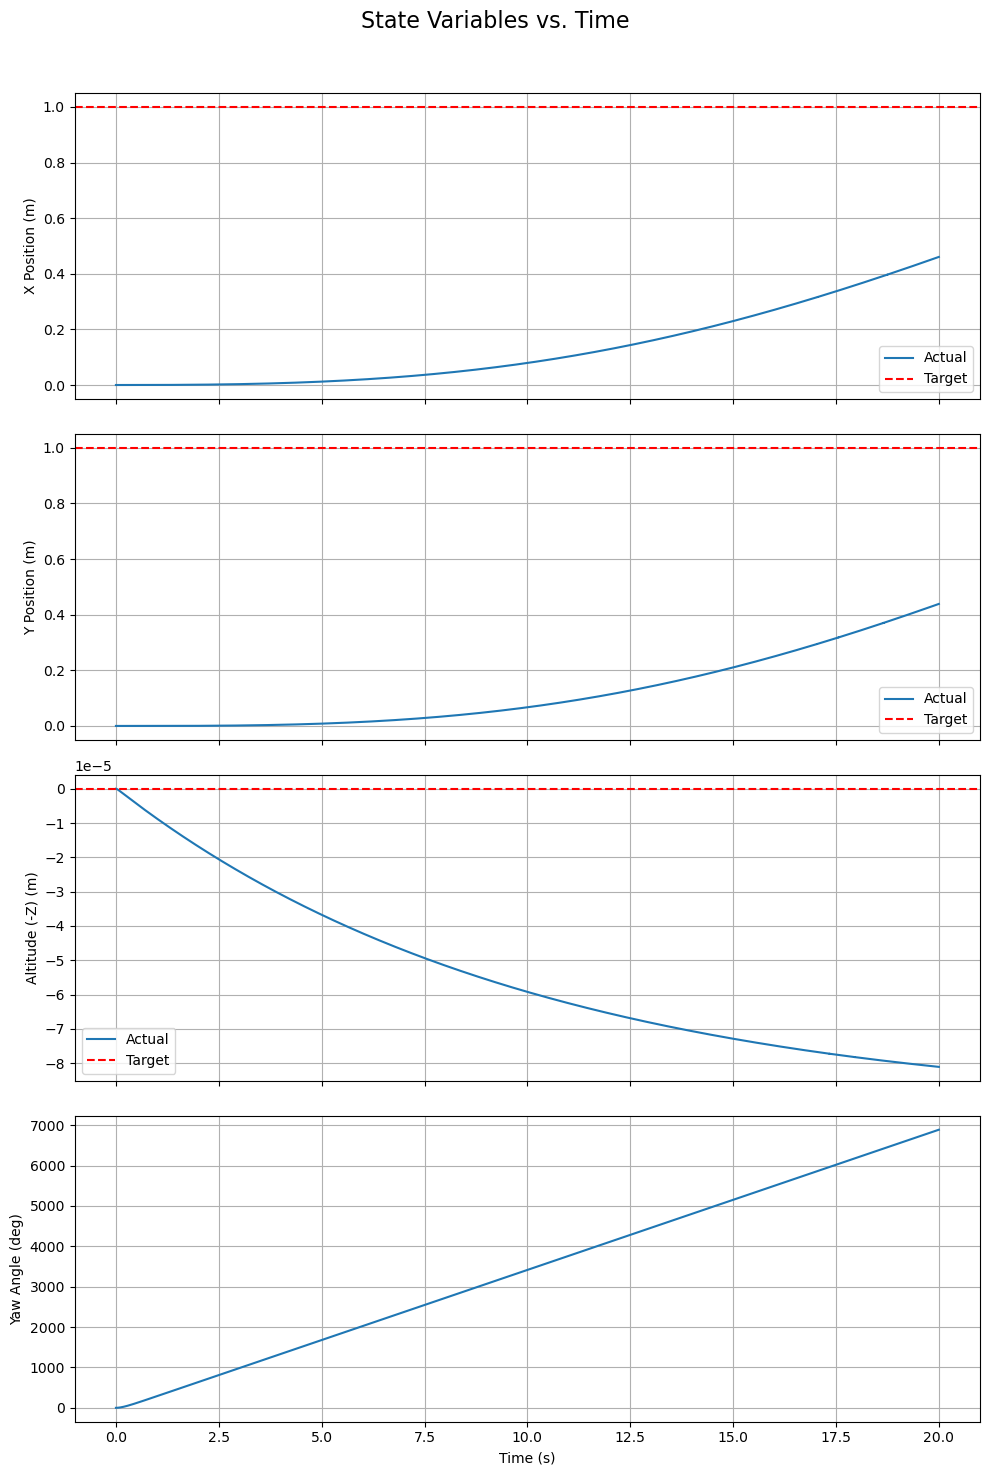

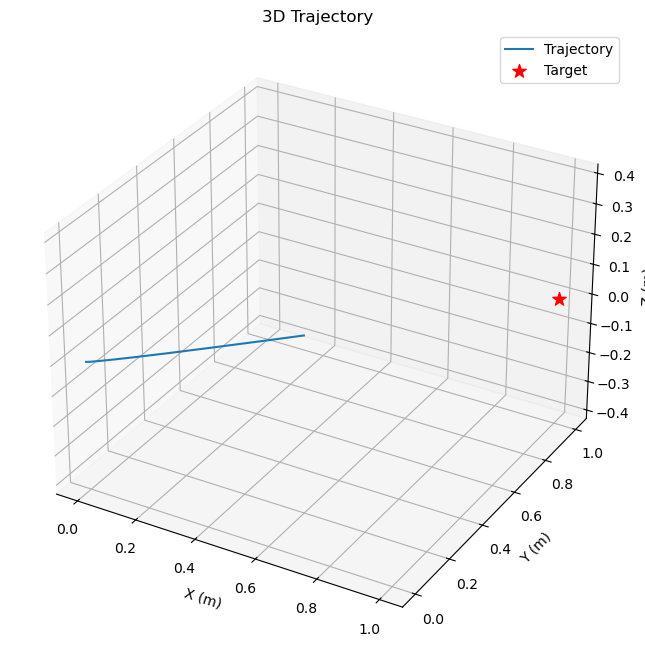

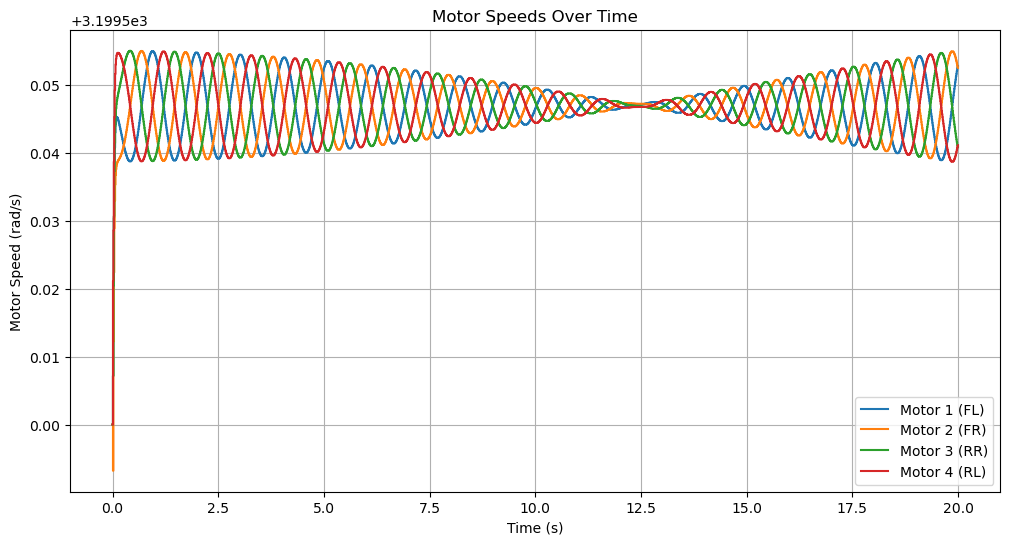

In [4]:
# Cell 4: Plotting the Results
def plot_matlab_results(times, states, target_pos):
    """
    Recreates the plots from the MATLAB script.
    """
    print("Generating plots...")
    
    X_des, Y_des, Z_des = target_pos
    
    # --- Figure 1 & 4 (Combined): Positions and Angles ---
    fig1, axs1 = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
    fig1.suptitle('State Variables vs. Time', fontsize=16)
    
    # X Position
    axs1[0].plot(times, states[:, 0], label='Actual')
    axs1[0].axhline(X_des, color='r', linestyle='--', label='Target')
    axs1[0].set_ylabel('X Position (m)'); axs1[0].grid(True); axs1[0].legend()
    
    # Y Position
    axs1[1].plot(times, states[:, 1], label='Actual')
    axs1[1].axhline(Y_des, color='r', linestyle='--', label='Target')
    axs1[1].set_ylabel('Y Position (m)'); axs1[1].grid(True); axs1[1].legend()

    # Z Position (Altitude)
    axs1[2].plot(times, -states[:, 2], label='Actual') # Inverted to match MATLAB plot
    axs1[2].axhline(-Z_des, color='r', linestyle='--', label='Target')
    axs1[2].set_ylabel('Altitude (-Z) (m)'); axs1[2].grid(True); axs1[2].legend()
    
    # Psi Angle (Yaw)
    axs1[3].plot(times, np.rad2deg(states[:, 5]))
    axs1[3].set_ylabel('Yaw Angle (deg)'); axs1[3].grid(True)
    axs1[3].set_xlabel('Time (s)')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # --- Figure 2: 3D Trajectory ---
    fig2 = plt.figure(figsize=(8, 8))
    ax3d = fig2.add_subplot(111, projection='3d')
    ax3d.plot(states[:, 0], states[:, 1], -states[:, 2], label='Trajectory')
    ax3d.scatter(X_des, Y_des, -Z_des, color='r', s=100, marker='*', label='Target')
    ax3d.set_xlabel('X (m)'); ax3d.set_ylabel('Y (m)'); ax3d.set_zlabel('Z (m)')
    ax3d.set_title('3D Trajectory'); ax3d.legend(); ax3d.grid(True)
    ax3d.axis('equal')

    # --- Figure 7: Motor Speeds ---
    fig7, ax7 = plt.subplots(figsize=(12, 6))
    ax7.plot(times, states[:, 12], label='Motor 1 (FL)')
    ax7.plot(times, states[:, 13], label='Motor 2 (FR)')
    ax7.plot(times, states[:, 14], label='Motor 3 (RR)')
    ax7.plot(times, states[:, 15], label='Motor 4 (RL)')
    ax7.set_xlabel('Time (s)'); ax7.set_ylabel('Motor Speed (rad/s)')
    ax7.set_title('Motor Speeds Over Time'); ax7.legend(); ax7.grid(True)
    
    plt.show()

# --- Call the plotting function ---
if 'states' in locals():
    plot_matlab_results(times, states, target_pos=(1.0, 1.0, 0.0))